<a href="https://colab.research.google.com/github/Ryan-Radawiec/Machine-Learning-Projects/blob/master/ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnet_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

**Needs resnet_utils file to be uploaded**


In [28]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    
    return X

In [35]:
#from tensorflow.python.framework import ops
#ops.reset_default_graph()     #this resets the graph
import tensorflow.compat.v1 as tf #This lets session run as v2 behavior doesn't allow sesison command
tf.disable_v2_behavior()     

tf.reset_default_graph() #This was the old code

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.        0.        1.3454674 2.0318177 0.        1.3246754]


**Convolutional block**

For the shortcut path, a convolution will need to be added so that the dimensions match up.

**First component of main path:**

The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be conv_name_base + '2a'.
The first BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2a'.

---



---


Then apply the ReLU activation function. This has no name and no hyperparameters.



---



**Second component of main path:**

The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same" and it's name should be conv_name_base + '2b'.
The second BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2b'.
Then apply the ReLU activation function. This has no name and no hyperparameters.




---


**Third component of main path:**

The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be conv_name_base + '2c'.
The third BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2c'. Note that there is no ReLU activation function in this component.



---


**Shortcut path:**

The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be conv_name_base + '1'.
The BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '1'.



---


**Final step**:

The shortcut and the main path values are added together.
Then apply the ReLU activation function. This has no name and no hyperparameters.

In [36]:
#Convolutional blocks

def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    #defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    #Retrieve Filters
    F1, F2, F3 = filters

    #save the input value
    X_shortcut = X

    ###MAIN PATH####
    #First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    #Second component of main path
    X = Conv2D(F2, (f,f),strides = (1,1), padding ='same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    #Third component of main path
    X = Conv2D(F3, (1,1), strides = (1,1), padding ='valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ######## Shortcut Path #####
    X_shortcut = Conv2D( F3, (1,1), strides = (s,s), padding='valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    #Final Step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [37]:

tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.        0.        0.        0.8929657 0.        0.1988273]



3 - **Building your first ResNet model** (50 layers)
You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.



---



The details of this ResNet-50 model are:

Zero-padding pads the input with a pad of (3,3)

**Stage 1:**

The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
BatchNorm is applied to the channels axis of the input.
MaxPooling uses a (3,3) window and a (2,2) stride.



---


**Stage 2:**

The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".



---


**Stage 3:**

The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".



---


**Stage 4:**

The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".



---


**Stage 5:**

The convolutional block uses three set of filters of size [512, 512, 2048], "f" 



is 3, "s" is 2 and the block is "a".

The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".

The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
The flatten doesn't have any hyperparameters or name.

The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be 'fc' + str(classes).

**RESNET50**

In [40]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """  

    #Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    #zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    #stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    #stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block ='a', s=1)
    X = identity_block(X, 3, [65,64,256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage =2, block='c')

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


    #Average Pooling Layer
    X = AveragePooling2D()(X)

    #output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)


    #Create Model
    model = Model(inputs = X_input, outputs = X, name ='ResNet50')

    return model

**Build the Model**

In [43]:
model = ResNet50(input_shape = (64, 64, 3), classes =6)

**Compiling the model**

In [44]:
#you must compile the model before training the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Loading the SIGNS Dataset**

In [48]:

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

#Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

#Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig,6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


**Train the Model**

In [54]:
model.fit(X_train, Y_train, epochs = 32, batch_size = 32)

Train on 1080 samples
Epoch 1/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.1990 - acc: 0.9537
Epoch 2/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.3641 - acc: 0.9278
Epoch 3/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.1049 - acc: 0.9648
Epoch 4/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.0352 - acc: 0.9880
Epoch 5/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.0216 - acc: 0.9991
Epoch 6/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.0067 - acc: 0.9981
Epoch 7/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.0027 - acc: 1.0000
Epoch 8/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.0029 - acc: 1.0000
Epoch 9/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.0127 - acc: 0.9972
Epoch 10/32
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.0221 -

**See how the model performs on the test set**

In [55]:
preds = model.evaluate(X_test, Y_test)
print("Loss =" + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

Loss =0.13692707245548566
Test Accuracy = 0.9583333


**TEST on your own Images**


In [56]:
#Will need to add an images folder in whatevre directory oyu are in



"""
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))
"""

'\nimg_path = \'images/my_image.jpg\'\nimg = image.load_img(img_path, target_size=(64, 64))\nx = image.img_to_array(img)\nx = np.expand_dims(x, axis=0)\nx = preprocess_input(x)\nprint(\'Input image shape:\', x.shape)\nmy_image = scipy.misc.imread(img_path)\nimshow(my_image)\nprint("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")\nprint(model.predict(x))\n'

**Model Summary**

In [57]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

**Visualize the RESNET50**

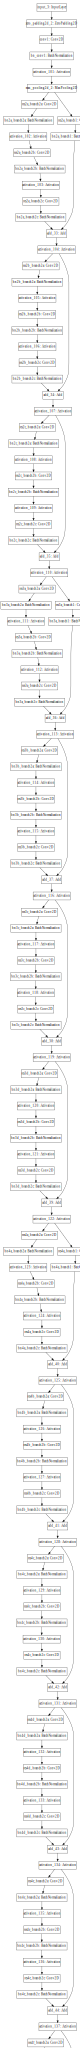

In [58]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))